아래는 ALO 기본 설정 및 라이브러리 설치 코드입니다. library 설치 에러가 발생하면 아래 셀을 재실행 하고, 지속적으로 문제가 있을 시 문의바랍니다

In [1]:
 import argparse
import time
import os
os.chdir(os.path.abspath(os.path.join('./alo')))
from src.alo import ALO
alo = ALO(); alo.preset(); pipelines = list(alo.asset_source.keys())
from src.external import external_load_data, external_save_artifacts

======================================== Start dependency installation : << master >> 
>> Start checking existence & installing package - alolib@git+http://mod.lge.com/hub/dxadvtech/aicontents-framework/alolib-source.git@release-1.1 | Progress: ( 1 / 1 total packages )
- << alolib@git+http://mod.lge.com/hub/dxadvtech/aicontents-framework/alolib-source.git@release-1.1 >> already exists
======================================== Start dependency installation : << force-reinstall >> 
======================================== Finish dependency installation 

STTIME does not exist. instead get current time
>> << /home/jovyan/gcr/alo/assets/ >> directory already exists.


## Train Workflow

In [4]:
# 아래는 Train 시 필요한 라이브러리를 설치하는 코드입니다. library 설치 에러가 발생하면 아래 셀을 재실행 해주세요
external_load_data(pipelines[0], alo.external_path, alo.external_path_permission, alo.control['get_external_data'])
pipeline = pipelines[0]
alo.install_steps(pipeline, alo.control["get_asset_source"])

[INFO] You did not write any << s3_private_key_file >> in the config yaml file. When you wanna get data from s3 storage, 
 you have to write the s3_private_key_file path or set << ACCESS_KEY, SECRET_KEY >> in your os environment. 

[INFO] Skip loading external data. << /nas001/users/seongwoo.kong/gcr_test_data/sample/ >> 
 << sample >> already exists in << /home/jovyan/gcr/alo/input/ >>. 
 & << get_external_data >> is set as << once >>. 

>> Start setting-up << input >> asset @ << assets >> directory.
[NOTICE] << input >> asset had already been created at 2023-10-26 05:47:41.591910
>> Start setting-up << graph >> asset @ << assets >> directory.
[NOTICE] << graph >> asset had already been created at 2023-10-26 05:47:42.037913
>> Start setting-up << preprocess >> asset @ << assets >> directory.
[NOTICE] << preprocess >> asset had already been created at 2023-10-26 05:47:42.783919
>> Start setting-up << sampling >> asset @ << assets >> directory.
[NOTICE] << sampling >> asset had already 

## Train workflow 
### 0. Input asset 
##### Input asset의 arguments 수정 및 확인
- 필요한경우 input_args의 항목을 ***input_args[argument명]=value입력*** 을 통해 변경할 수 있습니다.  

In [5]:
train_pipelines = 'train_pipeline'
# GCR asset 순서에 따라 step 순서를 입력합니다. (input(0) - graph(1) - preprocess(2) - sampling(3) - train(4))
step = 0 
input_args = alo.user_parameters[pipeline][step]['args'][0].copy()

# 아래 주석을 풀어 input_args를 원하는 값으로 수정합니다. 
# input_args['x_columns'] = ['']
input_args

{'input_path': 'sample',
 'x_columns': None,
 'use_all_x': True,
 'y_column': 'is_married',
 'groupkey_columns': None,
 'drop_columns': None,
 'time_column': None}

##### Input asset 실행 

In [6]:
data = pipe_val = {} # 초기 input asset process 세팅

data_input, config_input = alo.process_asset_step(alo.asset_source[pipeline][step], step, pipeline, data, pipe_val, [input_args])
# data_input: input asset의 결과물입니다. 다음 asset 실행 시 필요합니다. 
# config_input: input asset의 결과 config입니다. 다음 asset실행 시 필요합니다.

# input asset의 결과 dataframe은 data_input['dataframe']으로 확인할 수 있습니다. 
data_input['dataframe'].head(10) 

==================== current time : 2023-10-26 07:01:19.569988+00:00 (UTC) ====================
************************************************************
************************************************************
>> Load path : ['/home/jovyan/gcr/alo//input/sample/']
>> The file for batch data has been loaded. (File name: /home/jovyan/gcr/alo//input/sample/customers.csv)
You set the << use_all_x >> as << True >> in the yaml file. So skip checking dataframe columns existence.
==================== Success loading dataframe ====================
>> Start processing ignore columns & drop columns: ['/home/jovyan/gcr/alo//input/sample/customers.csv']
>> You set the << use_all_x >> parameter as << True >> in your config yaml. (So, these x_columns are used: ['name', 'FLAG_TRAIN_INFERENCE', 'age', 'address', 'spent', 'hobbies', 'job', 'orders', 'gender'] )
['name', 'FLAG_TRAIN_INFERENCE', 'age', 'address', 'spent', 'hobbies', 'job', 'orders', 'gender']


,name,address,gender,age,orders,spent,job,hobbies,is_married,FLAG_TRAIN_INFERENCE
0,Jasmine_Young,TN17745,female,80,0,233.44,Receptionist,Photography,False,TRAIN
1,Jeffery_Robinson,CT69980,male,42,15,264.70,Teacher,Fishing,True,TRAIN
2,Steven_Sullivan,CT13314,male,70,13,339.10,Janitor,Hiking,False,TRAIN
3,Jay_Williams,TN68283,male,27,7,70.61,Waitress,Playing musical instruments,False,TRAIN
4,Benjamin_Beck,AE11377,male,21,9,748.94,Farmer,Playing sports,True,TRAIN
5,Gregory_Gomez,FM04887,male,75,10,937.97,Unkown,Running,False,TRAIN
6,Mary_Harris,KS55063,female,60,12,60.97,Librarian,Reading,True,TRAIN
7,Jimmy_Smith,AL47190,male,72,5,468.64,Waitress,Sewing,False,TRAIN
8,Kenneth_Rubio,RI07301,male,74,15,482.72,Polic,Dancing,True,TRAIN
9,Jordan_Simmons,AA06497,female,41,1,156.16,Cashier,Baking,False,TRAIN


</br>

### 1. Graph asset 
##### Graph asset의 args수정 및 확인
- 필요한경우 graph_args의 항목을 ***graph_args의[argument명]=value입력*** 을 통해 변경할 수 있습니다.  

In [7]:
# GCR asset 순서에 따라 step 순서를 입력합니다. (input(0) - graph(1) - preprocess(2) - sampling(3) - train(4))
step = 1 
graph_args = alo.user_parameters[pipeline][step]['args'][0].copy()

# 아래 주석을 풀어 graph_args 수정합니다. 
# graph_args['graph_type'] = 'relational'
graph_args

{'graph_type': None,
 'center_node_column': 'name',
 'embedding_column': 'name',
 'train_inference_column': 'FLAG_TRAIN_INFERENCE',
 'drop_columns': [],
 'dimension': 64,
 'num_epochs': 1,
 'workers': None,
 'num_partitions': None,
 'extra_columns_for_ml': [],
 'custom_connection': []}

##### Graph asset 실행 

In [12]:
data_graph, config_graph = alo.process_asset_step(alo.asset_source[pipeline][step], step, pipeline, data_input, config_input.copy(), [graph_args])
# data_graph: graph asset의 결과물입니다. 다음 asset 실행 시 필요합니다. 
# config_graph: graph asset의 결과 config입니다. 다음 asset실행 시 필요합니다. 

# graph asset의 결과 dataframe은 data_graph['dataframe']으로 확인할 수 있습니다. 
data_graph['dataframe'].head(10) 

>> Successfully got << output path >> for saving your data into csv or jpg file: 
 /home/jovyan/gcr/alo//.train_artifacts/output/graph/ 
 L [NOTE] The names of output file must be fixed as << output.csv, output.jpg >> 
************************************************************
************************************************************
preprocessing blank space...
In __init__: pbg ready
[2023-10-26 07:13:33.587077] Using the 7 relation types given in the config
[2023-10-26 07:13:33.588337] Searching for the entities in the edge files...
[2023-10-26 07:13:33.680755] Entity type address:
[2023-10-26 07:13:33.681810] - Found 1000 entities
[2023-10-26 07:13:33.682820] - Removing the ones with fewer than 1 occurrences...
[2023-10-26 07:13:33.683989] - Left with 1000 entities
[2023-10-26 07:13:33.684985] - Shuffling them...
[2023-10-26 07:13:33.686736] Entity type name:
[2023-10-26 07:13:33.687902] - Found 985 entities
[2023-10-26 07:13:33.688926] - Removing the ones with fewer than 1 occ

/home/jovyan/conda/envs/gcr/lib/python3.10/site-packages/torchbiggraph/util.py:222: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = tensor.storage_type()._new_shared(size.numel())
/home/jovyan/conda/envs/gcr/lib/python3.10/site-packages/torch/storage.py:959: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if self.device.type not in ['cpu', 'cuda']:
/home/jovyan/conda/envs/gcr/lib/python3.10/site-packages/torch/storage.py:962: UserWarning: TypedStorage is deprecated. It will be removed in the future and Unty

2023-10-26 07:15:44,521   [Trainer-0] Creating workers...


/home/jovyan/conda/envs/gcr/lib/python3.10/site-packages/torchbiggraph/train_cpu.py:304: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  ).storage()


2023-10-26 07:15:48,727   [Trainer-0] Initializing global model...
2023-10-26 07:15:49,528   [Trainer-0] Starting epoch 1 / 1, edge path 1 / 7, edge chunk 1 / 2
2023-10-26 07:15:49,531   [Trainer-0] Edge path: /home/jovyan/gcr/alo//.train_artifacts/output/graph/partitions/edges_partitioned_rel_3
2023-10-26 07:15:49,532   [Trainer-0] still in queue: 0
2023-10-26 07:15:49,533   [Trainer-0] Swapping partitioned embeddings None ( 0 , 0 )
2023-10-26 07:15:49,534   [Trainer-0] Loading partitioned embeddings from checkpoint
2023-10-26 07:16:34,443   [Trainer-0] ( 0 , 0 ): Training stats: loss:  10.0362 , reg:  0.00110181 , violators_lhs:  73.962 , violators_rhs:  74.264 , count:  500
2023-10-26 07:16:34,445   [Trainer-0] ( 0 , 0 ): bucket 1 / 1 : Trained 500 edges in 42.47 s ( 1.2e-05 M/sec ); Eval 2*0 edges in 0.00 s ( 0 M/sec ); io: 2.44 s for 650,720 bytes ( 0.27 MB/sec )
2023-10-26 07:16:34,446   [Trainer-0] Swapping partitioned embeddings ( 0 , 0 ) None
2023-10-26 07:16:34,447   [Trainer

/home/jovyan/conda/envs/gcr/lib/python3.10/site-packages/torchbiggraph/train_cpu.py:821: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  self.embedding_storage_freelist[entity].add(embs.storage())


2023-10-26 07:16:34,718   [Trainer-0] ( 0 , 0 ): Training stats: loss:  10.0395 , reg:  0.00110294 , violators_lhs:  75.2545 , violators_rhs:  75.503 , count:  499
2023-10-26 07:16:34,719   [Trainer-0] ( 0 , 0 ): bucket 1 / 1 : Trained 499 edges in 0.06 s ( 0.0083 M/sec ); Eval 2*0 edges in 0.00 s ( 0 M/sec ); io: 0.10 s for 650,696 bytes ( 6.75 MB/sec )
2023-10-26 07:16:34,720   [Trainer-0] Swapping partitioned embeddings ( 0 , 0 ) None
2023-10-26 07:16:34,721   [Trainer-0] Saving partitioned embeddings to checkpoint
2023-10-26 07:16:34,780   [Trainer-0] Finished epoch 1 / 1, edge path 1 / 7, edge chunk 2 / 2
2023-10-26 07:16:34,781   [Trainer-0] Writing the metadata
2023-10-26 07:16:35,401   [Trainer-0] Writing the training stats
2023-10-26 07:16:35,404   [Trainer-0] Writing the checkpoint
2023-10-26 07:16:35,405   [Trainer-0] Switching to the new checkpoint version
2023-10-26 07:16:35,414   [Trainer-0] Starting epoch 1 / 1, edge path 2 / 7, edge chunk 1 / 2
2023-10-26 07:16:35,417  

,name,is_married,EMB_00,EMB_01,EMB_02,EMB_03,EMB_04,EMB_05,EMB_06,EMB_07,...,EMB_54,EMB_55,EMB_56,EMB_57,EMB_58,EMB_59,EMB_60,EMB_61,EMB_62,EMB_63
0,Jasmine_Young,False,0.016538,-0.008067,-0.007596,-0.000633,0.001607,0.016212,-0.010445,-0.013139,...,0.004342,-0.000188,0.007250,-0.002752,0.000798,-0.004680,-0.004442,0.008832,-0.021160,-0.003933
1,Jeffery_Robinson,True,0.017017,-0.022626,0.001806,0.000938,0.016354,0.010338,0.003199,0.007888,...,0.001560,0.007903,0.003097,-0.003179,-0.002239,0.000408,-0.013558,0.012339,0.011655,0.012075
2,Steven_Sullivan,False,0.004450,0.000489,-0.007673,-0.012033,0.008483,-0.015631,-0.005434,0.002231,...,-0.008088,-0.006004,0.008902,0.003953,0.006039,0.003814,0.008377,0.000476,-0.001416,-0.003754
3,Jay_Williams,False,0.001083,-0.011676,-0.005207,0.008740,-0.003923,0.001176,0.004290,0.016565,...,0.002825,-0.000051,0.001242,-0.001760,-0.002549,0.007215,-0.020126,0.001544,-0.009346,-0.005447
4,Benjamin_Beck,True,-0.025749,-0.008956,0.011284,0.021791,-0.008500,0.007442,-0.025526,-0.010672,...,-0.001501,-0.005327,0.005365,0.001235,-0.002955,-0.008059,-0.017144,-0.021904,0.002713,0.009757
5,Gregory_Gomez,False,0.006974,-0.003312,-0.005165,-0.011515,0.005372,0.015446,0.012202,0.002737,...,0.001540,0.001889,0.023558,0.006070,0.022578,0.000108,0.008357,0.007082,-0.003001,0.018339
6,Mary_Harris,True,0.006794,0.006037,-0.024521,-0.009489,-0.010266,0.009738,-0.007976,0.002430,...,-0.009119,0.008931,0.007925,-0.022432,0.009433,0.008259,-0.005597,-0.006701,-0.012634,0.015962
7,Jimmy_Smith,False,-0.007756,-0.013257,-0.002573,0.009958,-0.001874,-0.003488,0.005286,0.018059,...,0.001500,0.001745,0.002381,-0.000217,0.000012,0.008409,-0.015855,-0.001234,-0.013331,-0.005641
8,Kenneth_Rubio,True,0.007522,-0.018704,-0.000111,-0.008999,-0.009502,-0.006239,0.000093,0.022828,...,0.014636,0.010824,-0.005042,0.003140,0.010190,0.009326,-0.018076,-0.001034,0.004514,0.003176
9,Jordan_Simmons,False,0.014809,-0.020393,-0.005992,-0.000668,0.012844,-0.003438,-0.012427,-0.011591,...,0.006650,-0.001765,0.008347,-0.004738,0.016266,-0.004600,-0.006485,0.009370,-0.010399,0.010310


</br>

### 2. Preprocess asset 
##### Preprocess asset의 args수정 및 확인
- 필요한경우 preprocess_args의 항목을 ***preprocess_args[argument명]=value입력*** 을 통해 변경할 수 있습니다.  

In [13]:
# GCR asset 순서에 따라 step 순서를 입력합니다. (input(0) - graph(1) - preprocess(2) - sampling(3) - train(4))
step = 2 
preprocess_args = alo.user_parameters[pipeline][step]['args'][0].copy()

# 아래 주석을 풀어 preprocess_args 수정합니다. 
# preprocess_args['handling_missing'] = 'interpolation'
preprocess_args

{'handling_missing': 'interpolation',
 'handling_encoding_y_column': 'is_married',
 'handling_encoding_y': 'label',
 'limit_encoding_categories': 30,
 'load_train_preprocess': False}

##### Preprocess asset 실행 

In [14]:
data_preprocess, config_preprocess = alo.process_asset_step(alo.asset_source[pipeline][step], step, pipeline, data_graph, config_graph.copy(), [preprocess_args])
# data_preprocess: preprocess asset의 결과물입니다. 다음 asset 실행 시 필요합니다. 
# config_preprocess: preprocess asset의 결과 config입니다. 다음 asset실행 시 필요합니다. 

# preprocess asset의 결과 dataframe은 data_preprocess['dataframe']으로 확인할 수 있습니다. 
data_preprocess['dataframe'].head(10) 

>> Successfully got model path for saving or loading your AI model: 
 /home/jovyan/gcr/alo//.train_artifacts/models/preprocess/
************************************************************
************************************************************
is_married column : label Encoder saved : /home/jovyan/gcr/alo//.train_artifacts/models/preprocess/
['EMB_00_nan', 'EMB_01_nan', 'EMB_02_nan', 'EMB_03_nan', 'EMB_04_nan', 'EMB_05_nan', 'EMB_06_nan', 'EMB_07_nan', 'EMB_08_nan', 'EMB_09_nan', 'EMB_10_nan', 'EMB_11_nan', 'EMB_12_nan', 'EMB_13_nan', 'EMB_14_nan', 'EMB_15_nan', 'EMB_16_nan', 'EMB_17_nan', 'EMB_18_nan', 'EMB_19_nan', 'EMB_20_nan', 'EMB_21_nan', 'EMB_22_nan', 'EMB_23_nan', 'EMB_24_nan', 'EMB_25_nan', 'EMB_26_nan', 'EMB_27_nan', 'EMB_28_nan', 'EMB_29_nan', 'EMB_30_nan', 'EMB_31_nan', 'EMB_32_nan', 'EMB_33_nan', 'EMB_34_nan', 'EMB_35_nan', 'EMB_36_nan', 'EMB_37_nan', 'EMB_38_nan', 'EMB_39_nan', 'EMB_40_nan', 'EMB_41_nan', 'EMB_42_nan', 'EMB_43_nan', 'EMB_44_nan', 'EMB_45_nan', 'EMB_

fatal: No names found, cannot describe anything.


,EMB_00,EMB_01,EMB_02,EMB_03,EMB_04,EMB_05,EMB_06,EMB_07,EMB_08,EMB_09,...,EMB_55_nan,EMB_56_nan,EMB_57_nan,EMB_58_nan,EMB_59_nan,EMB_60_nan,EMB_61_nan,EMB_62_nan,EMB_63_nan,is_married_encoded_nan
0,0.016538,-0.008067,-0.007596,-0.000633,0.001607,0.016212,-0.010445,-0.013139,0.002467,0.002639,...,-0.000188,0.007250,-0.002752,0.000798,-0.004680,-0.004442,0.008832,-0.021160,-0.003933,0
1,0.017017,-0.022626,0.001806,0.000938,0.016354,0.010338,0.003199,0.007888,0.013356,-0.004954,...,0.007903,0.003097,-0.003179,-0.002239,0.000408,-0.013558,0.012339,0.011655,0.012075,1
2,0.004450,0.000489,-0.007673,-0.012033,0.008483,-0.015631,-0.005434,0.002231,0.005285,0.005549,...,-0.006004,0.008902,0.003953,0.006039,0.003814,0.008377,0.000476,-0.001416,-0.003754,0
3,0.001083,-0.011676,-0.005207,0.008740,-0.003923,0.001176,0.004290,0.016565,-0.005768,0.000586,...,-0.000051,0.001242,-0.001760,-0.002549,0.007215,-0.020126,0.001544,-0.009346,-0.005447,0
4,-0.025749,-0.008956,0.011284,0.021791,-0.008500,0.007442,-0.025526,-0.010672,-0.001578,0.000359,...,-0.005327,0.005365,0.001235,-0.002955,-0.008059,-0.017144,-0.021904,0.002713,0.009757,1
5,0.006974,-0.003312,-0.005165,-0.011515,0.005372,0.015446,0.012202,0.002737,-0.010678,0.018531,...,0.001889,0.023558,0.006070,0.022578,0.000108,0.008357,0.007082,-0.003001,0.018339,0
6,0.006794,0.006037,-0.024521,-0.009489,-0.010266,0.009738,-0.007976,0.002430,-0.010220,-0.014123,...,0.008931,0.007925,-0.022432,0.009433,0.008259,-0.005597,-0.006701,-0.012634,0.015962,1
7,-0.007756,-0.013257,-0.002573,0.009958,-0.001874,-0.003488,0.005286,0.018059,0.001619,0.003831,...,0.001745,0.002381,-0.000217,0.000012,0.008409,-0.015855,-0.001234,-0.013331,-0.005641,0
8,0.007522,-0.018704,-0.000111,-0.008999,-0.009502,-0.006239,0.000093,0.022828,-0.003850,-0.003091,...,0.010824,-0.005042,0.003140,0.010190,0.009326,-0.018076,-0.001034,0.004514,0.003176,1
9,0.014809,-0.020393,-0.005992,-0.000668,0.012844,-0.003438,-0.012427,-0.011591,0.007965,0.006985,...,-0.001765,0.008347,-0.004738,0.016266,-0.004600,-0.006485,0.009370,-0.010399,0.010310,0


</br>

### 3. Sampling asset 
##### Sampling asset의 args수정 및 확인
- 필요한경우 Sampling_args의 항목을 ***sampling_args[argument명]=value입력*** 을 통해 변경할 수 있습니다.  

In [15]:
# GCR asset 순서에 따라 step 순서를 입력합니다. (input(0) - graph(1) - preprocess(2) - sampling(3) - train(4))
step = 3 
sampling_args = alo.user_parameters[pipeline][step]['args'][0].copy()

# 아래 주석을 풀어 preprocess_args 수정합니다. 
# sampling_args['sampling_type'] = 'under'
sampling_args

{'sampling_type': 'none',
 'sampling_method': 'negative',
 'label_sampling': True,
 'ignore_label_class': 1,
 'negative_target_class': None,
 'label_sampling_num_type': 'compare',
 'label_sampling_num': {1: 1, 0: 25},
 'sampling_groupkey_columns': None,
 'sampling_num_type': None,
 'sampling_num': None}

##### Sampling asset 실행 

In [16]:
data_sampling, config_sampling = alo.process_asset_step(alo.asset_source[pipeline][step], step, pipeline, data_preprocess, config_preprocess.copy(), [sampling_args])
# data_sampling: sampling asset의 결과물입니다. 다음 asset 실행 시 필요합니다. 
# config_sampling: sampling asset의 결과 config입니다. 다음 asset실행 시 필요합니다. 

# sampling asset의 결과 dataframe은 data_sampling['dataframe']으로 확인할 수 있습니다. 
data_sampling['dataframe'].head(10) 

/home/jovyan/conda/envs/gcr/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


************************************************************
************************************************************
>> Successfully got model path for saving or loading your AI model: 
 /home/jovyan/gcr/alo//.train_artifacts/models/sampling/


,EMB_00,EMB_01,EMB_02,EMB_03,EMB_04,EMB_05,EMB_06,EMB_07,EMB_08,EMB_09,...,EMB_55_nan,EMB_56_nan,EMB_57_nan,EMB_58_nan,EMB_59_nan,EMB_60_nan,EMB_61_nan,EMB_62_nan,EMB_63_nan,is_married_encoded_nan
0,0.016538,-0.008067,-0.007596,-0.000633,0.001607,0.016212,-0.010445,-0.013139,0.002467,0.002639,...,-0.000188,0.007250,-0.002752,0.000798,-0.004680,-0.004442,0.008832,-0.021160,-0.003933,0
1,0.017017,-0.022626,0.001806,0.000938,0.016354,0.010338,0.003199,0.007888,0.013356,-0.004954,...,0.007903,0.003097,-0.003179,-0.002239,0.000408,-0.013558,0.012339,0.011655,0.012075,1
2,0.004450,0.000489,-0.007673,-0.012033,0.008483,-0.015631,-0.005434,0.002231,0.005285,0.005549,...,-0.006004,0.008902,0.003953,0.006039,0.003814,0.008377,0.000476,-0.001416,-0.003754,0
3,0.001083,-0.011676,-0.005207,0.008740,-0.003923,0.001176,0.004290,0.016565,-0.005768,0.000586,...,-0.000051,0.001242,-0.001760,-0.002549,0.007215,-0.020126,0.001544,-0.009346,-0.005447,0
4,-0.025749,-0.008956,0.011284,0.021791,-0.008500,0.007442,-0.025526,-0.010672,-0.001578,0.000359,...,-0.005327,0.005365,0.001235,-0.002955,-0.008059,-0.017144,-0.021904,0.002713,0.009757,1
5,0.006974,-0.003312,-0.005165,-0.011515,0.005372,0.015446,0.012202,0.002737,-0.010678,0.018531,...,0.001889,0.023558,0.006070,0.022578,0.000108,0.008357,0.007082,-0.003001,0.018339,0
6,0.006794,0.006037,-0.024521,-0.009489,-0.010266,0.009738,-0.007976,0.002430,-0.010220,-0.014123,...,0.008931,0.007925,-0.022432,0.009433,0.008259,-0.005597,-0.006701,-0.012634,0.015962,1
7,-0.007756,-0.013257,-0.002573,0.009958,-0.001874,-0.003488,0.005286,0.018059,0.001619,0.003831,...,0.001745,0.002381,-0.000217,0.000012,0.008409,-0.015855,-0.001234,-0.013331,-0.005641,0
8,0.007522,-0.018704,-0.000111,-0.008999,-0.009502,-0.006239,0.000093,0.022828,-0.003850,-0.003091,...,0.010824,-0.005042,0.003140,0.010190,0.009326,-0.018076,-0.001034,0.004514,0.003176,1
9,0.014809,-0.020393,-0.005992,-0.000668,0.012844,-0.003438,-0.012427,-0.011591,0.007965,0.006985,...,-0.001765,0.008347,-0.004738,0.016266,-0.004600,-0.006485,0.009370,-0.010399,0.010310,0


</br>

### 4. Train asset 
##### Train asset의 args수정 및 확인
- 필요한경우 train_args의 항목을 ***train_args[argument명]=value입력*** 을 통해 변경할 수 있습니다.  

In [17]:
# GCR asset 순서에 따라 step 순서를 입력합니다. (input(0) - graph(1) - preprocess(2) - sampling(3) - train(4))
step = 4 
tcr_args = alo.user_parameters[pipeline][step]['args'][0].copy()

# 아래 주석을 풀어 tcr_args를 수정합니다. 
# tcr_args['model_list'] = ['lgb']
tcr_args

{'model_type': 'classification',
 'data_split_method': 'cross_validate',
 'evaluation_metric': 'accuracy',
 'model_list': ['lgb', 'rf', 'gbm', 'cb'],
 'num_hpo': 3,
 'param_range': {'rf': {'max_depth': 6, 'n_estimators': [300, 500]},
  'gbm': {'max_depth': [5, 7], 'n_estimators': [300, 500]},
  'ngb': {'col_sample': [0.6, 0.8], 'n_estimators': [100, 300]},
  'lgb': {'max_depth': [5, 9], 'n_estimators': [300, 500]},
  'cb': {'max_depth': [5, 9], 'n_estimators': [100, 500]}},
 'shap_ratio': 1.0,
 'evaluation_report': False}

##### Train asset 실행 

************************************************************
************************************************************
>> Successfully got model path for saving or loading your AI model: 
 /home/jovyan/gcr/alo//.train_artifacts/models/train/
>> Successfully got << output path >> for saving your data into csv or jpg file: 
 /home/jovyan/gcr/alo//.train_artifacts/output/train/ 
 L [NOTE] The names of output file must be fixed as << output.csv, output.jpg >> 
>> Successfully got << report path >> for saving your << report.html >> file: 
 /home/jovyan/gcr/alo//.train_artifacts/report/
해당 column 은 Training 과정에 사용되지 않습니다. (column_name: ['EMB_38', 'EMB_20', 'EMB_18', 'EMB_16', 'EMB_58', 'EMB_36', 'EMB_60', 'EMB_42', 'EMB_56', 'EMB_04', 'EMB_09', 'EMB_54', 'is_married', 'EMB_55', 'EMB_08', 'EMB_52', 'EMB_22', 'EMB_37', 'EMB_43', 'EMB_59', 'EMB_39', 'EMB_26', 'EMB_62', 'EMB_07', 'EMB_45', 'EMB_25', 'EMB_11', 'EMB_12', 'EMB_06', 'EMB_23', 'EMB_29', 'EMB_47', 'EMB_15', 'EMB_61', 'EMB_19', 'EMB


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[INFO] 0th-fold RandomForestClassifier_set0 모델을 학습합니다.(1/48)
[INFO] 1th-fold RandomForestClassifier_set0 모델을 학습합니다.(2/48)
[INFO] 2th-fold RandomForestClassifier_set0 모델을 학습합니다.(3/48)
[INFO] 3th-fold RandomForestClassifier_set0 모델을 학습합니다.(4/48)
[INFO] 0th-fold RandomForestClassifier_set1 모델을 학습합니다.(5/48)
[INFO] 1th-fold RandomForestClassifier_set1 모델을 학습합니다.(6/48)
[INFO] 2th-fold RandomForestClassifier_set1 모델을 학습합니다.(7/48)
[INFO] 3th-fold RandomForestClassifier_set1 모델을 학습합니다.(8/48)
[INFO] 0th-fold RandomForestClassifier_set2 모델을 학습합니다.(9/48)
[INFO] 1th-fold RandomForestClassifier_set2 모델을 학습합니다.(10/48)
[INFO] 2th-fold RandomForestClassifier_set2 모델을 학습합니다.(11/48)
[INFO] 3th-fold RandomForestClassifier_set2 모델을 학습합니다.(12/48)
[INFO] 0th-fold GradientBoostingClassifier_set0 모델을 학습합니다.(13/48)
[INFO] 1th-fold GradientBoostingClassifier_set0 모델을 학습합니다.(14/48)
[INFO] 2th-fold GradientBoostingClassifier_set0 모델을 학습합니다.(15/48)
[INFO] 3th-fold GradientBoostingClassifier_set0 모델을 학습합니다.(16/48)
[

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


[INFO] 평가 지표는 ( accuracy ) 를 사용합니다. 
모델 정보 로그를 저장합니다. (저장위치: /home/jovyan/gcr/alo//.train_artifacts/models/train/model_selection.json)
모델 파일을 저장합니다. (저장위치: /home/jovyan/gcr/alo//.train_artifacts/models/train/best_model_top0.pkl)
모델 파일을 저장합니다. (저장위치: /home/jovyan/gcr/alo//.train_artifacts/models/train/best_model_top1.pkl)
모델 파일을 저장합니다. (저장위치: /home/jovyan/gcr/alo//.train_artifacts/models/train/best_model_top2.pkl)
[INFO] Summary_plot for Train data 를 저장했습니다.



,EMB_00,EMB_01,EMB_02,EMB_03,EMB_04,EMB_05,EMB_06,EMB_07,EMB_08,EMB_09,...,x61_shapley,x62_shapley,x63_shapley,y0,y0_pred,y0_pred_best0,y0_pred_best1,y0_pred_best2,y0_prob,y1_prob
0,-0.003840,0.002288,-0.007967,-0.002356,-0.005350,0.013863,0.006603,0.006003,-0.013113,0.019675,...,0.001273,0.001753,-0.006309,0,0,0,0,0,0.686593,0.313407
1,-0.009052,0.013082,0.021508,0.015092,-0.004068,0.019373,0.013463,-0.003814,-0.032021,0.014427,...,0.002812,0.002801,-0.000661,0,0,0,0,0,0.590732,0.409268
2,0.004987,0.008661,-0.008990,0.018038,0.014452,-0.014352,0.019380,0.051285,-0.013601,0.028915,...,-0.001597,0.002254,-0.003488,0,0,0,0,0,0.674853,0.325147
3,0.001998,-0.016198,-0.005150,-0.003461,-0.019599,-0.006972,-0.004956,-0.007177,-0.003454,-0.023739,...,-0.000064,0.002890,-0.003445,0,0,0,0,0,0.519094,0.480906
4,-0.020020,0.011530,-0.007236,-0.015067,-0.009421,-0.005364,-0.023002,-0.000690,0.002372,0.001262,...,0.002253,0.001335,0.005789,0,0,0,0,0,0.814324,0.185676
5,-0.011804,0.015293,-0.000414,0.014433,-0.003025,-0.006060,0.012435,-0.008691,0.002073,-0.017985,...,-0.000014,0.000366,0.000861,1,0,0,0,0,0.771844,0.228156
6,0.015265,-0.004064,-0.008829,-0.002126,-0.009262,0.016647,0.002565,-0.003330,0.007537,-0.007018,...,0.000022,-0.000100,-0.007688,1,0,0,0,0,0.766870,0.233130
7,-0.015778,-0.011173,0.014553,-0.001650,-0.011929,0.005844,-0.003917,0.007704,-0.002859,-0.006877,...,0.000617,-0.023057,0.000237,1,0,0,0,0,0.594031,0.405969
8,0.008968,0.006837,-0.002328,0.014541,0.006340,0.003762,-0.009290,0.002642,-0.002153,0.007673,...,0.001483,-0.006740,-0.001670,0,0,0,0,0,0.624811,0.375189
9,0.005291,-0.000264,0.004244,0.013976,-0.007684,-0.023415,0.007039,-0.012200,-0.012685,-0.014295,...,-0.000028,0.001810,0.005918,0,0,0,0,0,0.700137,0.299863


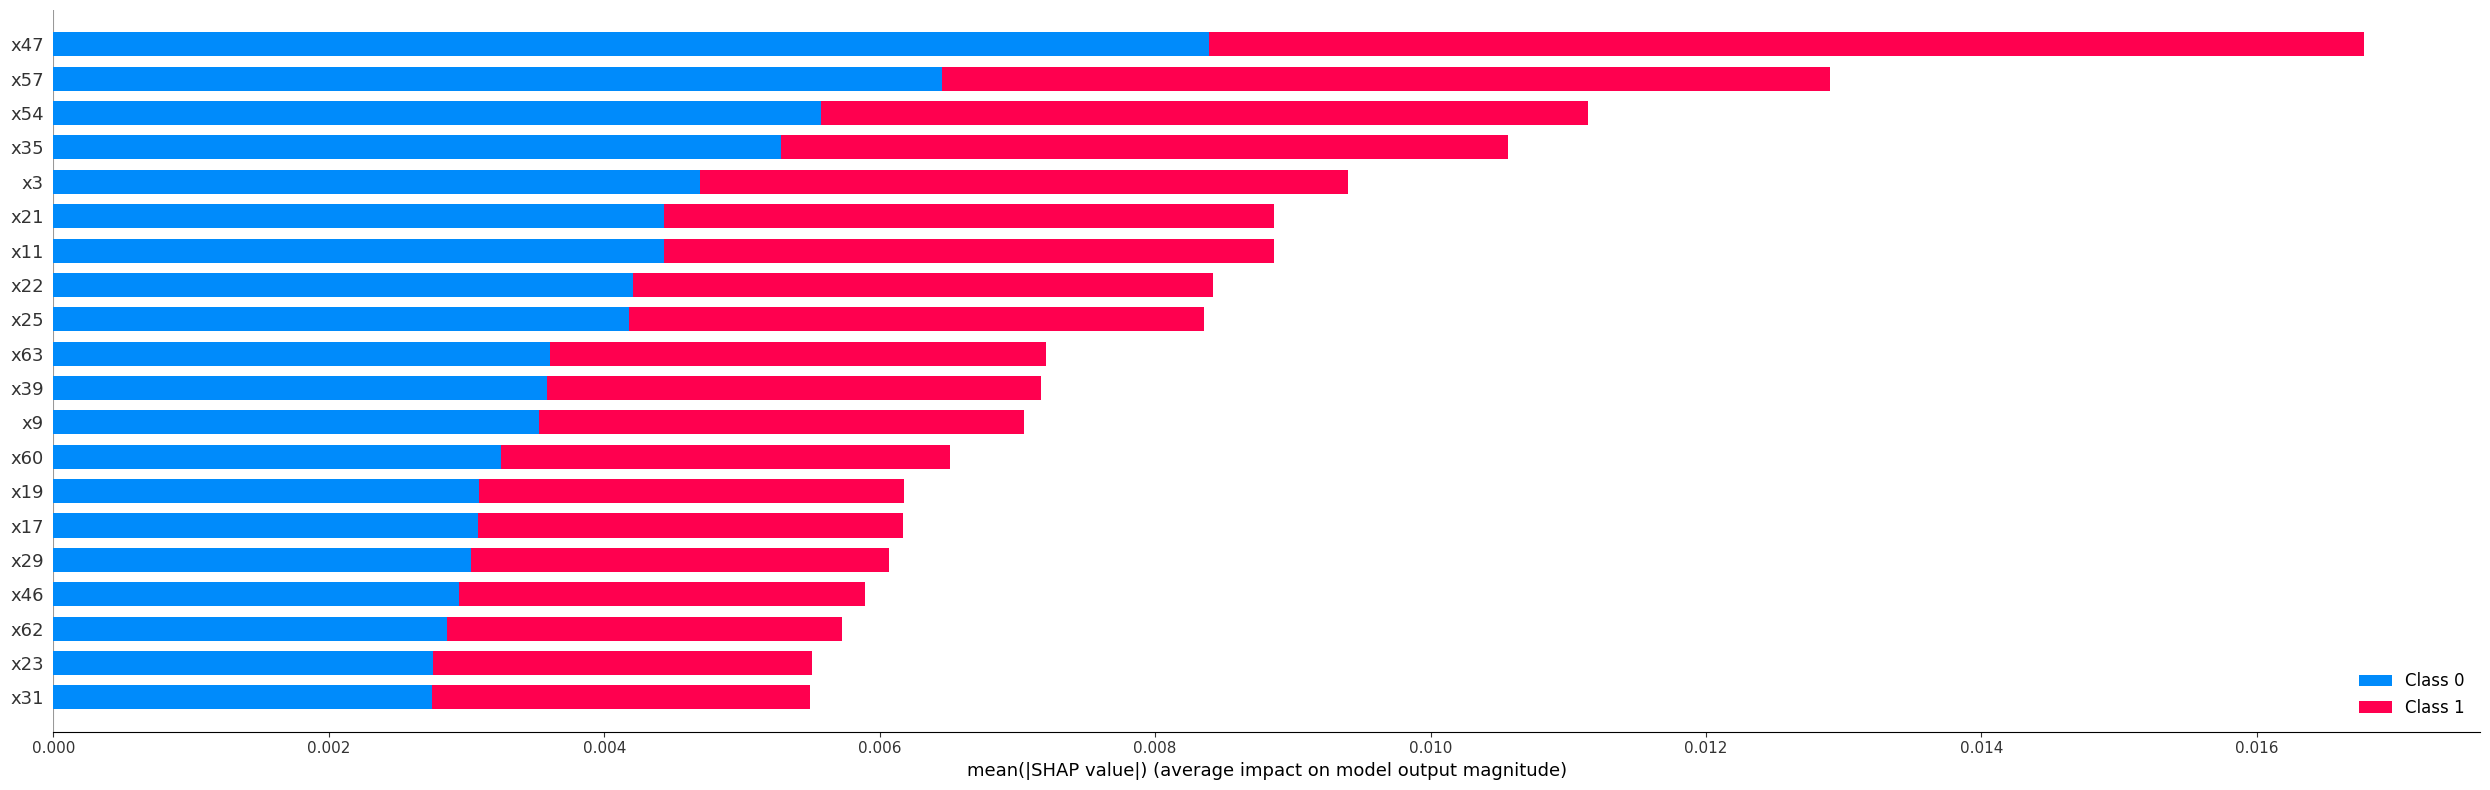

In [19]:
data_tcr, config_tcr = alo.process_asset_step(alo.asset_source[pipeline][step], step, pipeline, data_sampling, config_sampling.copy(), [tcr_args])
# data_tcr: TCR asset의 결과물입니다. 
# config_tcr: TCR asset의 결과 config입니다. 

# tcr asset의 결과 dataframe은 data_tcr['dataframe']으로 확인할 수 있습니다. 
data_tcr['dataframe'].head(10) 

<br>

## Inference workflow 

In [20]:
# 아래는 Inference 시 필요한 라이브러리를 설치하는 코드입니다. library 설치 에러가 발생하면 아래 셀을 재실행 해주세요
external_load_data(pipelines[1], alo.external_path, alo.external_path_permission, alo.control['get_external_data'])
pipeline = pipelines[1]
alo.install_steps(pipeline, alo.control["get_asset_source"])

[INFO] You did not write any << s3_private_key_file >> in the config yaml file. When you wanna get data from s3 storage, 
 you have to write the s3_private_key_file path or set << ACCESS_KEY, SECRET_KEY >> in your os environment. 

>> Start setting-up << input >> asset @ << assets >> directory.
[NOTICE] << input >> asset had already been created at 2023-10-26 07:00:57.015663
>> Start setting-up << preprocess >> asset @ << assets >> directory.
@ local asset_source_code mode: <preprocess> asset exists.
>> Start setting-up << inference >> asset @ << assets >> directory.
>> Start renewing asset : /home/jovyan/gcr/alo/assets/inference
/home/jovyan/gcr/alo/assets/inference successfully pulled.
>> Start setting-up << result >> asset @ << assets >> directory.
>> Start renewing asset : /home/jovyan/gcr/alo/assets/result
/home/jovyan/gcr/alo/assets/result successfully pulled.
>> Ignored installing << pandas==1.5.3 >>. Another version will be installed in the previous step.
>> Ignored installing 

### 0. Input asset 
##### Input asset의 arguments 수정 및 확인
- 필요한경우 input_args의 항목을 ***input_args[argument명]=value입력*** 을 통해 변경할 수 있습니다.  

In [21]:
# GCR inference asset 순서에 따라 step 순서를 입력합니다. (input(0) - preprocess(1) - inference(2) - result(3))
step = 0 
input_args = alo.user_parameters[pipeline][step]['args'][0].copy()

# 아래 주석을 풀어 input_args를 원하는 값으로 수정합니다. 
# input_args['x_columns'] = ['']
input_args

{'input_path': 'inference',
 'x_columns': None,
 'use_all_x': True,
 'y_column': None,
 'groupkey_columns': None,
 'drop_columns': None,
 'time_column': None}

##### Input asset 실행 

In [22]:
data = pipe_val = {} # 초기 input asset process 세팅

data_input, config_input = alo.process_asset_step(alo.asset_source[pipeline][step], step, pipeline, data, pipe_val, [input_args])
# data_input: input asset의 결과물입니다. 다음 asset 실행 시 필요합니다. 
# config_input: input asset의 결과 config입니다. 다음 asset실행 시 필요합니다.

# input asset의 결과 dataframe은 data_input['dataframe']으로 확인할 수 있습니다. 
data_input['dataframe'].head(10) 

==================== current time : 2023-10-26 07:22:53.172617+00:00 (UTC) ====================
************************************************************
************************************************************
>> Load path : ['/home/jovyan/gcr/alo//input/inference/']
>> The file for batch data has been loaded. (File name: /home/jovyan/gcr/alo//input/inference/inference.csv)
You set the << use_all_x >> as << True >> in the yaml file. So skip checking dataframe columns existence.
==================== Success loading dataframe ====================
>> Start processing ignore columns & drop columns: ['/home/jovyan/gcr/alo//input/inference/inference.csv']
>> You set the << use_all_x >> parameter as << True >> in your config yaml. (So, these x_columns are used: ['EMB_38', 'EMB_20', 'EMB_18', 'EMB_16', 'EMB_58', 'EMB_36', 'EMB_60', 'EMB_42', 'EMB_56', 'EMB_04', 'EMB_09', 'EMB_54', 'EMB_55', 'EMB_08', 'EMB_52', 'EMB_22', 'EMB_37', 'EMB_43', 'EMB_59', 'EMB_39', 'EMB_26', 'EMB_62', 'EMB_0

,EMB_00,EMB_01,EMB_02,EMB_03,EMB_04,EMB_05,EMB_06,EMB_07,EMB_08,EMB_09,...,EMB_54,EMB_55,EMB_56,EMB_57,EMB_58,EMB_59,EMB_60,EMB_61,EMB_62,EMB_63
0,-0.011227,0.015182,0.002597,-0.003921,-0.009704,-0.000640,0.011198,0.040924,0.007627,0.023322,...,0.000512,0.007250,-0.014137,0.009595,-0.013396,0.009082,-0.005512,-0.002132,-0.004012,-0.000962
1,-0.027682,0.010461,-0.019723,-0.010939,0.003469,0.016413,0.018254,0.000670,-0.020169,0.003201,...,-0.002303,-0.003304,-0.017208,0.001646,0.016926,0.022633,0.016857,-0.029941,-0.004121,-0.001152
2,0.021544,0.002321,0.008405,-0.029040,-0.025740,-0.002588,0.009490,0.004514,0.018385,0.013275,...,-0.004590,-0.015337,0.007174,0.013639,0.004892,0.012634,-0.007335,-0.013596,-0.005158,0.003181
3,-0.011922,0.017357,-0.002228,-0.001493,0.008546,-0.010302,0.012404,0.002372,-0.013243,0.000979,...,0.005986,-0.019676,0.002127,0.001586,0.006836,0.044418,0.003059,-0.008317,-0.016886,0.014883
4,-0.000818,0.026582,-0.013543,-0.033014,0.006545,0.009701,0.002904,0.009885,-0.012798,-0.007768,...,-0.025573,-0.005811,-0.001401,0.006665,-0.015317,0.006962,-0.002084,-0.019869,-0.000995,0.013414
5,0.020523,0.022243,-0.006265,-0.013159,-0.037123,-0.008584,-0.006340,0.004897,0.017507,0.006336,...,0.004591,-0.012558,-0.008265,-0.002984,0.030888,-0.029008,-0.033700,-0.001579,0.003421,0.010323
6,-0.003530,-0.015738,-0.006244,0.002629,0.003296,0.009335,-0.001652,0.010254,-0.003611,0.011273,...,0.002548,-0.002409,0.009906,-0.000665,-0.014496,-0.007891,0.011762,-0.013416,-0.010920,-0.006670
7,0.017136,0.009767,0.014779,0.008059,-0.000736,0.024253,0.016696,0.001120,-0.035895,0.030446,...,0.028112,-0.015401,0.005603,-0.002173,0.017057,0.009590,-0.009864,0.003798,-0.024084,0.031504
8,0.033809,0.001664,0.006406,-0.019290,-0.017561,0.002544,-0.000144,0.007823,-0.002898,0.014413,...,0.004245,0.006260,-0.004780,0.001977,0.002419,-0.003927,0.007886,-0.016147,0.012642,-0.014983
9,-0.001256,0.011899,-0.009817,0.007280,-0.043979,-0.023253,0.002523,0.000154,-0.003941,-0.039277,...,-0.008892,-0.014480,-0.005024,-0.028099,-0.006470,0.025809,-0.024412,-0.001494,-0.019587,-0.002925


</br>

### 1. Preprocess asset 
##### Preprocess asset의 args수정 및 확인
- 필요한경우 preprocess_args의 항목을 ***preprocess_args[argument명]=value입력*** 을 통해 변경할 수 있습니다.  

In [23]:
# GCR inference asset 순서에 따라 step 순서를 입력합니다. (input(0) - preprocess(1) - inference(2) - result(3))
step = 1 
preprocess_args = alo.user_parameters[pipeline][step]['args'][0].copy()

# 아래 주석을 풀어 preprocess_args 수정합니다. 
# preprocess_args['handling_missing'] = 'interpolation'
preprocess_args

{'handling_missing': 'interpolation',
 'handling_encoding_y_column': None,
 'limit_encoding_categories': 30,
 'load_train_preprocess': True}

##### Preprocess asset 실행 

In [24]:
data_preprocess, config_preprocess = alo.process_asset_step(alo.asset_source[pipeline][step], step, pipeline, data_input, config_input.copy(), [preprocess_args])
# data_preprocess: preprocess asset의 결과물입니다. 다음 asset 실행 시 필요합니다. 
# config_preprocess: preprocess asset의 결과 config입니다. 다음 asset실행 시 필요합니다. 

# preprocess asset의 결과 dataframe은 data_preprocess['dataframe']으로 확인할 수 있습니다. 
data_preprocess['dataframe'].head(10) 

>> Successfully got model path for saving or loading your AI model: 
 /home/jovyan/gcr/alo//.train_artifacts/models/preprocess/
************************************************************
************************************************************
['EMB_38_nan', 'EMB_20_nan', 'EMB_18_nan', 'EMB_16_nan', 'EMB_58_nan', 'EMB_36_nan', 'EMB_60_nan', 'EMB_42_nan', 'EMB_56_nan', 'EMB_04_nan', 'EMB_09_nan', 'EMB_54_nan', 'EMB_55_nan', 'EMB_08_nan', 'EMB_52_nan', 'EMB_22_nan', 'EMB_37_nan', 'EMB_43_nan', 'EMB_59_nan', 'EMB_39_nan', 'EMB_26_nan', 'EMB_62_nan', 'EMB_07_nan', 'EMB_45_nan', 'EMB_25_nan', 'EMB_11_nan', 'EMB_12_nan', 'EMB_06_nan', 'EMB_23_nan', 'EMB_29_nan', 'EMB_47_nan', 'EMB_61_nan', 'EMB_15_nan', 'EMB_19_nan', 'EMB_49_nan', 'EMB_17_nan', 'EMB_53_nan', 'EMB_30_nan', 'EMB_32_nan', 'EMB_27_nan', 'EMB_40_nan', 'EMB_31_nan', 'EMB_48_nan', 'EMB_02_nan', 'EMB_14_nan', 'EMB_57_nan', 'EMB_46_nan', 'EMB_63_nan', 'EMB_01_nan', 'EMB_13_nan', 'EMB_33_nan', 'EMB_21_nan', 'EMB_03_nan', 'EMB_51

fatal: No names found, cannot describe anything.


,EMB_38,EMB_20,EMB_18,EMB_16,EMB_58,EMB_36,EMB_60,EMB_42,EMB_56,EMB_04,...,EMB_05_nan,EMB_41_nan,EMB_00_nan,EMB_44_nan,EMB_34_nan,EMB_28_nan,EMB_10_nan,EMB_35_nan,EMB_50_nan,EMB_24_nan
0,-0.031011,0.014823,-0.024925,-0.003508,-0.013396,-0.018555,-0.005512,0.029787,-0.014137,-0.009704,...,-0.000640,-0.019736,-0.011227,0.005069,0.016305,0.019516,0.015590,-0.022317,-0.000181,-0.024142
1,-0.015606,0.007733,0.006381,0.011617,0.016926,0.033393,0.016857,0.005872,-0.017208,0.003469,...,0.016413,-0.004436,-0.027682,-0.022899,-0.003409,0.018568,0.018375,0.007061,0.000035,-0.008296
2,-0.027343,0.009834,-0.012177,-0.010790,0.004892,0.008763,-0.007335,-0.008777,0.007174,-0.025740,...,-0.002588,-0.000235,0.021544,0.005860,0.010677,-0.002425,0.006936,0.014337,0.006457,0.001680
3,-0.001033,0.035589,-0.025108,0.011112,0.006836,-0.005146,0.003059,-0.000790,0.002127,0.008546,...,-0.010302,0.006835,-0.011922,0.015190,-0.004980,0.022811,0.022793,-0.030626,0.000888,-0.010933
4,-0.000823,0.008647,0.004431,-0.000183,-0.015317,0.011087,-0.002084,0.007036,-0.001401,0.006545,...,0.009701,-0.024108,-0.000818,-0.007217,0.018639,-0.004010,-0.016046,0.029978,0.010655,-0.006701
5,0.002510,-0.007344,-0.004544,0.036327,0.030888,0.004079,-0.033700,-0.005674,-0.008265,-0.037123,...,-0.008584,0.036134,0.020523,0.013542,-0.012563,0.012050,-0.015265,-0.008885,-0.005132,0.012273
6,0.007830,-0.016144,0.006649,0.001771,-0.014496,-0.010096,0.011762,0.008549,0.009906,0.003296,...,0.009335,0.013090,-0.003530,-0.008928,0.000528,-0.004509,-0.014907,-0.002927,0.020503,0.013235
7,-0.012708,-0.009585,-0.028099,0.014349,0.017057,-0.015230,-0.009864,0.012561,0.005603,-0.000736,...,0.024253,0.014879,0.017136,-0.022676,0.019442,0.013341,0.001322,-0.006273,0.003189,0.001766
8,-0.008812,-0.006370,0.000837,-0.008975,0.002419,-0.012096,0.007886,-0.002530,-0.004780,-0.017561,...,0.002544,0.011761,0.033809,-0.006096,0.004464,0.014591,-0.001417,0.006506,-0.001833,0.007646
9,0.016117,0.023265,-0.003688,-0.008485,-0.006470,0.010499,-0.024412,0.003755,-0.005024,-0.043979,...,-0.023253,0.028730,-0.001256,0.005802,-0.005851,0.000064,0.011507,0.007737,0.012933,0.025491


<br>

### 2. Inference asset 
##### Inference asset의 args수정 및 확인
- 필요한경우 inference_args의 항목을 ***inference_args[argument명]=value입력*** 을 통해 변경할 수 있습니다.  

In [25]:
# GCR inference asset 순서에 따라 step 순서를 입력합니다. (input(0) - preprocess(1) - inference(2) - result(3))
step = 2
tcr_args = alo.user_parameters[pipeline][step]['args'][0].copy()

# 아래 주석을 풀어 tcr_args를 수정합니다. 
# tcr_args['model_type'] = 
tcr_args

{'model_type': 'classification'}

##### inference asset 실행 

In [26]:
data_tcr, config_tcr = alo.process_asset_step(alo.asset_source[pipeline][step], step, pipeline, data_preprocess, config_preprocess.copy(), [tcr_args])
# data_tcr: TCR asset의 결과물입니다. 
# config_tcr: TCR asset의 결과 config입니다. 

# tcr asset의 결과 dataframe은 data_tcr['dataframe']으로 확인할 수 있습니다. 
data_tcr['dataframe'].head(10)


 ################################### inference_init (sec):  5.9604644775390625e-05 ################################### 

************************************************************
************************************************************
>> Successfully got model path for saving or loading your AI model: 
 /home/jovyan/gcr/alo//.train_artifacts/models/train/
>> Successfully got << output path >> for saving your data into csv or jpg file: 
 /home/jovyan/gcr/alo//.inference_artifacts/output/inference/ 
 L [NOTE] The names of output file must be fixed as << output.csv, output.jpg >> 
ignore_columns는 Training 과정에 사용되지 않습니다.
[INFO] XAI 분석 시, 활용할 모델을 로드합니다.
모델을 Load 완료 하였습니다. (모델 위치: /home/jovyan/gcr/alo//.train_artifacts/models/train/best_model_top0.pkl)
################################joblib load model time:  0.09248661994934082 s###########################################


,EMB_00,EMB_01,EMB_02,EMB_03,EMB_04,EMB_05,EMB_06,EMB_07,EMB_08,EMB_09,...,x56,x57,x58,x59,x60,x61,x62,x63,prediction,prediction_score
0,-0.011227,0.015182,0.002597,-0.003921,-0.009704,-0.000640,0.011198,0.040924,0.007627,0.023322,...,-0.014137,0.009595,-0.013396,0.009082,-0.005512,-0.002132,-0.004012,-0.000962,0,"[0.6351386734434903, 0.36486132655650916]"
1,-0.027682,0.010461,-0.019723,-0.010939,0.003469,0.016413,0.018254,0.000670,-0.020169,0.003201,...,-0.017208,0.001646,0.016926,0.022633,0.016857,-0.029941,-0.004121,-0.001152,0,"[0.6943764275721842, 0.30562357242781585]"
2,0.021544,0.002321,0.008405,-0.029040,-0.025740,-0.002588,0.009490,0.004514,0.018385,0.013275,...,0.007174,0.013639,0.004892,0.012634,-0.007335,-0.013596,-0.005158,0.003181,0,"[0.6624854911063665, 0.3375145088936336]"
3,-0.011922,0.017357,-0.002228,-0.001493,0.008546,-0.010302,0.012404,0.002372,-0.013243,0.000979,...,0.002127,0.001586,0.006836,0.044418,0.003059,-0.008317,-0.016886,0.014883,0,"[0.7143277863393447, 0.2856722136606552]"
4,-0.000818,0.026582,-0.013543,-0.033014,0.006545,0.009701,0.002904,0.009885,-0.012798,-0.007768,...,-0.001401,0.006665,-0.015317,0.006962,-0.002084,-0.019869,-0.000995,0.013414,0,"[0.6451080860347516, 0.35489191396524883]"
5,0.020523,0.022243,-0.006265,-0.013159,-0.037123,-0.008584,-0.006340,0.004897,0.017507,0.006336,...,-0.008265,-0.002984,0.030888,-0.029008,-0.033700,-0.001579,0.003421,0.010323,0,"[0.6467639579366166, 0.35323604206338366]"
6,-0.003530,-0.015738,-0.006244,0.002629,0.003296,0.009335,-0.001652,0.010254,-0.003611,0.011273,...,0.009906,-0.000665,-0.014496,-0.007891,0.011762,-0.013416,-0.010920,-0.006670,0,"[0.7875577871744598, 0.21244221282553982]"
7,0.017136,0.009767,0.014779,0.008059,-0.000736,0.024253,0.016696,0.001120,-0.035895,0.030446,...,0.005603,-0.002173,0.017057,0.009590,-0.009864,0.003798,-0.024084,0.031504,0,"[0.633962306591046, 0.3660376934089537]"
8,0.033809,0.001664,0.006406,-0.019290,-0.017561,0.002544,-0.000144,0.007823,-0.002898,0.014413,...,-0.004780,0.001977,0.002419,-0.003927,0.007886,-0.016147,0.012642,-0.014983,0,"[0.7882125364073506, 0.21178746359264902]"
9,-0.001256,0.011899,-0.009817,0.007280,-0.043979,-0.023253,0.002523,0.000154,-0.003941,-0.039277,...,-0.005024,-0.028099,-0.006470,0.025809,-0.024412,-0.001494,-0.019587,-0.002925,0,"[0.6189925375541533, 0.3810074624458469]"


<br>

### 3. Result asset 
##### Result asset의 args수정 및 확인
- 필요한경우 Result_args의 항목을 ***result_args[argument명]=value입력*** 을 통해 변경할 수 있습니다.  

In [27]:
# GCR inference asset 순서에 따라 step 순서를 입력합니다. (input(0) - preprocess(1) - inference(2) - result(3))
step = 3
result_args = alo.user_parameters[pipeline][step]['args'][0].copy()

# 아래 주석을 풀어 result_args를 수정합니다. 
# tcr_args['model_type'] = 
result_args

{'result_save_name': None}

##### result asset 실행 

In [29]:
data_result, config_result = alo.process_asset_step(alo.asset_source[pipeline][step], step, pipeline, data_tcr, config_tcr.copy(), [result_args])
# data_result: result asset의 결과물입니다. 
# config_result: result asset의 결과 config입니다. 

# result asset의 결과 dataframe은 data_result['dataframe']으로 확인할 수 있습니다. 
data_result['dataframe'].head(10)

************************************************************
************************************************************
Loading Embeddings
>> Successfully got model path for saving or loading your AI model: 
 /home/jovyan/gcr/alo//.train_artifacts/models/result/
Merging data
>> Successfully got << output path >> for saving your data into csv or jpg file: 
 /home/jovyan/gcr/alo//.inference_artifacts/output/result/ 
 L [NOTE] The names of output file must be fixed as << output.csv, output.jpg >> 
>> Successfully got << output path >> for saving your data into csv or jpg file: 
 /home/jovyan/gcr/alo//.inference_artifacts/output/result/ 
 L [NOTE] The names of output file must be fixed as << output.csv, output.jpg >> 
Check Result at /home/jovyan/gcr/alo//.inference_artifacts/output/result/inference_result.csv


,name,is_married,prediction
0,Gregory_Hull,NaN,0
1,Allison_Peterson,NaN,0
2,Daniel_Davies,NaN,0
3,Alison_Fox,NaN,0
4,Daniel_Moore,NaN,0
5,Barbara_Smith,NaN,0
6,Paul_Terry,NaN,0
7,Christina_Salas,NaN,0
8,Jose_Boyd,NaN,0
9,Zachary_Fowler,NaN,0
